# Sentiment Classification: Deep Learning (LSTM) Approach
This notebook demonstrates sentiment classification using a deep learning model (LSTM) with Keras.

**Approach:**
- Load and clean text data (lowercase, remove HTML, numbers, punctuation, stopwords).
- Tokenize and pad text sequences for LSTM input.
- Encode labels and convert to one-hot vectors.
- Build and train a Bidirectional LSTM model (with hyperparameter tuning).
- Evaluate using accuracy, precision, recall, F1-score, and confusion matrix.
- Save the trained model, tokenizer, and encoder for future use.

**Assumptions:**
- Input CSVs have at least two columns: text and label (notebook will rename if needed).
- Data is already split into train and test sets via CSVs.
- Labels are binary (0/1 or negative/positive).
- NLTK stopwords are downloaded at runtime if not present.
- For larger datasets, increase epochs and tune hyperparameters as needed.

In [1]:
# Install TensorFlow
%pip install tensorflow

  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.32.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached wrapt-1.17.3-cp313-cp313-win_amd64.whl.metadata (6.5 kB)
  Using cac

In [41]:
# Import all required libraries for data loading, preprocessing, deep learning (TensorFlow/Keras), evaluation, and saving models
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fhjib\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
# Load your training and test data from the Data folder
train_path = os.path.join('..', 'Data', 'train_data.csv')
test_path = os.path.join('..', 'Data', 'test_data.csv')

In [43]:
# Load the training and test CSVs into pandas DataFrames
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [44]:
# Text cleaning: lowercase, remove HTML, numbers, punctuation, and stopwords
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

In [45]:
# Ensure correct columns for both datasets before cleaning
for df, name in zip([train_df, test_df], ['train', 'test']):
    cols = list(df.columns)
    if 'text' not in cols or 'label' not in cols:
        print(f"{name} columns found: {cols}")
        if len(cols) >= 2:
            df.rename(columns={cols[0]: 'text', cols[1]: 'label'}, inplace=True)
        else:
            raise ValueError(f"{name} CSV must have at least two columns for text and label.")

train columns found: ['0', '1']
test columns found: ['0', '1']


In [46]:
train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

In [47]:
# Set the vocabulary size and sequence length for our tokenizer and padding
max_words = 20000
maxlen = 200

In [48]:
# Convert text to padded sequences for the LSTM model
tokenizer = keras.preprocessing.text.Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df['clean_text'])
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
X_test_seq  = tokenizer.texts_to_sequences(test_df['clean_text'])
X_train = keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test  = keras.preprocessing.sequence.pad_sequences(X_test_seq,  maxlen=maxlen, padding='post', truncating='post')

In [ ]:
# Encode the labels as integers and one-hot vectors for training
le = LabelEncoder()
y_train = le.fit_transform(train_df['label'])
y_test  = le.transform(test_df['label'])
num_classes = len(le.classes_)
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat  = keras.utils.to_categorical(y_test,  num_classes)

In [26]:
# Build a simple LSTM model for text classification
embedding_dim = 128
model = keras.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=maxlen),
    layers.Bidirectional(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

c:\Coding Segment\Projects\Sentiment-Classification-ML-DL\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [29]:
# Compile and train the LSTM model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, validation_split=0.1, epochs=5, batch_size=64)

Epoch 1/5


KeyboardInterrupt: 

In [ ]:
# Plot training and validation loss and accuracy curves to visualize overfitting/underfitting
if 'history' not in locals():
    raise RuntimeError("You must run the model training cell (that defines 'history') before plotting these curves.")
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter tuning: Try different values for embedding_dim, LSTM units, and batch size
from tensorflow.keras.callbacks import EarlyStopping

embedding_dims = [64, 128]
lstm_units = [32, 64]
batch_sizes = [32, 64]
best_val_acc = 0
best_params = {}

for emb in embedding_dims:
    for lstm in lstm_units:
        for batch in batch_sizes:
            print(f'Training with embedding_dim={emb}, lstm_units={lstm}, batch_size={batch}')
            model = keras.Sequential([
                layers.Embedding(input_dim=max_words, output_dim=emb, input_length=maxlen),
                layers.Bidirectional(layers.LSTM(lstm, dropout=0.2, recurrent_dropout=0.2)),
                layers.Dense(64, activation='relu'),
                layers.Dense(num_classes, activation='softmax')
            ])
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            es = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
            history = model.fit(
                X_train, y_train_cat,
                validation_split=0.1,
                epochs=5,
                batch_size=batch,
                callbacks=[es],
                verbose=0
            )
            val_acc = max(history.history['val_accuracy'])
            print(f'Validation accuracy: {val_acc:.4f}')
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {'embedding_dim': emb, 'lstm_units': lstm, 'batch_size': batch}

print('Best validation accuracy:', best_val_acc)
print('Best parameters:', best_params)

In [ ]:
# Evaluate the model on the test set and compute accuracy, precision, recall, and F1-score
y_pred_prob = model.predict(X_test)
y_pred_idx = y_pred_prob.argmax(axis=1)
acc = accuracy_score(y_test, y_pred_idx)
prec = precision_score(y_test, y_pred_idx, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred_idx, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_idx, average='weighted', zero_division=0)

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step


In [ ]:
# Show accuracy, precision, recall, and F1-score
print(f'Accuracy  : {acc:.4f}')
print(f'Precision : {prec:.4f}')
print(f'Recall    : {rec:.4f}')
print(f'F1-score  : {f1:.4f}')

Accuracy  : 0.8310
Precision : 0.8310
Recall    : 0.8310
F1-score  : 0.8310


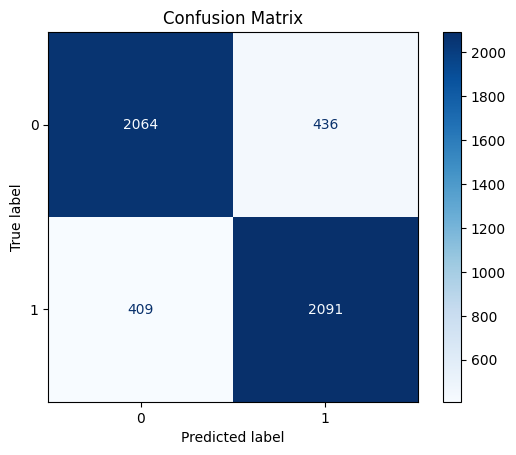

In [ ]:
# Visualize the confusion matrix for the LSTM model's predictions
cm = confusion_matrix(y_test, y_pred_idx)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the trained LSTM model to the Files directory
os.makedirs('Files', exist_ok=True)
model.save(os.path.join('Files', 'lstm_model.h5'))

In [ ]:
# Save the tokenizer and label encoder for future predictions
os.makedirs('Files', exist_ok=True)
joblib.dump(tokenizer, os.path.join('Files', 'tokenizer.joblib'))
joblib.dump(le, os.path.join('Files', 'encoder.joblib'))
'Saved'

'Saved'

In [ ]:
# Load saved model, tokenizer, and encoder, then run an interactive prediction
model = tf.keras.models.load_model(os.path.join('Files', 'lstm_model.h5'))
tokenizer = joblib.load(os.path.join('Files', 'tokenizer.joblib'))
le = joblib.load(os.path.join('Files', 'encoder.joblib'))

def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=200, padding='post', truncating='post')
    pred_idx = np.argmax(model.predict(padded), axis=1)[0]
    label = le.classes_[pred_idx]
    if str(label) == '1':
        return 'Positive'
    elif str(label) == '0':
        return 'Negative'
    else:
        return label

user_input = input('Enter a sentence: ')
print('Predicted sentiment:', predict_sentiment(user_input))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
Predicted sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
Predicted sentiment: Positive
